In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
!sudo apt install -y fonts-nanum*  > /dev/null
!sudo fc-cache -fv                 > /dev/null
!rm ~/.cache/matplotlib -rf        > /dev/null
mpl.rc('font', family='NanumGothic')

mpl.rc('axes', unicode_minus=False)

In [451]:
hs = '/content/drive/MyDrive/4조_헬스케어/자료파일/1차전처리/healthcare_edit.csv'
df = '/content/drive/MyDrive/4조_헬스케어/자료파일/1차전처리/인구대비데이터정리.csv'
ar = '/content/drive/MyDrive/4조_헬스케어/자료파일/1차전처리/면적(2019).csv'

hs = pd.read_csv(hs)
df = pd.read_csv(df)
ar = pd.read_csv(ar)

## 요양급여비+입내원일수 추가

In [459]:
hs.dtypes

Unnamed: 0      int64
가입자 일련번호        int64
연령대코드           int64
시도코드            int64
서식코드            int64
진료과목코드          int64
주상병코드          object
입내원일수           int64
심결가산율         float64
심결요양급여비용총액      int64
dtype: object

In [460]:
df2 = hs.groupby('시도코드')[['입내원일수', '심결요양급여비용총액']].sum()
df2.head()

,입내원일수,심결요양급여비용총액
시도코드,,
11,4191024,187836166960
21,1914593,85683171090
22,1113887,50084064620
23,1272059,59609191530
24,696180,32915444680


In [461]:
df3 = pd.merge(df, df2, on='시도코드')
del df3['Unnamed: 0']
df3.rename(columns={'십만명당 회피가능사망율':'십만명당 회피가능사망수'},inplace=True)
df3.head(3)

,시도코드,시도명,십만명당 회피가능사망수,총 인구,주민등록인구,의료인수합계,의사,간호사,천명당 의료인수,천명당 의사수,천명당 간호사수,병상수합계,천명당 병상수,요양기관합계,상급종합병원,종합병원,병원,의원,천명당 요양기관수,천명당 상급+종합병원수,입내원일수,심결요양급여비용총액
0,11,서울특별시,66.496942,9639541,9729107,114861,30359,52727,11.805914,3.120430,5.419511,88059,9.1,8924,13,44,228,8628,0.917248,0.005859,4191024,187836166960
1,21,부산광역시,86.370176,3372692,3413841,37028,8008,18514,10.846434,2.345745,5.423217,69862,20.5,2576,4,25,142,2384,0.754575,0.008495,1914593,85683171090
2,22,대구광역시,61.359540,2429940,2438031,26087,5908,12557,10.700028,2.423267,5.150468,38132,15.6,1950,5,11,109,1803,0.799826,0.006563,1113887,50084064620


In [462]:
df3['인구당 요양급여비'] = df3['심결요양급여비용총액'] / df3['총 인구']
df3['인구당 입내원일수'] = df3['입내원일수'] / df3['총 인구']
df4 = pd.merge(df3, ar, on='시도코드')
del df4['Unnamed: 0']
del df4['시도']
df4.head(3)

,시도코드,시도명,십만명당 회피가능사망수,총 인구,주민등록인구,의료인수합계,의사,간호사,천명당 의료인수,천명당 의사수,천명당 간호사수,병상수합계,천명당 병상수,요양기관합계,상급종합병원,종합병원,병원,의원,천명당 요양기관수,천명당 상급+종합병원수,입내원일수,심결요양급여비용총액,인구당 요양급여비,인구당 입내원일수,면적(2019)
0,11,서울특별시,66.496942,9639541,9729107,114861,30359,52727,11.805914,3.120430,5.419511,88059,9.1,8924,13,44,228,8628,0.917248,0.005859,4191024,187836166960,19486.007369,0.434774,605237001.6
1,21,부산광역시,86.370176,3372692,3413841,37028,8008,18514,10.846434,2.345745,5.423217,69862,20.5,2576,4,25,142,2384,0.754575,0.008495,1914593,85683171090,25404.979491,0.567675,770073413.2
2,22,대구광역시,61.359540,2429940,2438031,26087,5908,12557,10.700028,2.423267,5.150468,38132,15.6,1950,5,11,109,1803,0.799826,0.006563,1113887,50084064620,20611.235100,0.458401,883517307.5


In [463]:
df4['면적대비 요양기관수'] = df4['요양기관합계'] / df4['면적(2019)']

## 의료기관 내 의료종사자 수 전처리

In [464]:
em = '/content/drive/MyDrive/4조_헬스케어/자료파일/1차전처리/employees.csv'
em = pd.read_csv(em)
em.head(5)

,시도,요양기관종별,의사계,간호사계
0,서울,소계,30359,52727
1,서울,상급종합병원,9910,22931
2,서울,종합병원,5191,14164
3,서울,병원,2074,6031
4,서울,의원,12413,4722


In [465]:
em.replace(['서울', '부산', '인천', '대구', '광주', '대전', '울산', '경기', '강원', '충북', '충남',
       '전북', '전남', '경북', '경남', '제주', '세종'],
       ['11', '21', '23', '22', '24', '25', '26', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '29'],inplace=True)
em = em[em['요양기관종별'] != '소계']
em = em[em['요양기관종별'] != '병원']
em = em[em['요양기관종별'] != '의원']
em.rename(columns={'시도':'시도코드'},inplace=True)
em.rename(columns={'의사계':'상급의료기관 의사계'},inplace=True)
em = em.groupby('시도코드')['상급의료기관 의사계'].sum().to_frame()

In [466]:

city = ['서울', '부산', '대구', '인천',  '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남',
       '전북', '전남', '경북', '경남', '제주', ]
em['시도명'] = city

In [467]:
em = em.set_index('시도명')

In [468]:
city_n = ['11','21','22','23','24','25','26','29','31','32','33','34','35','36','37','38','39']
em['시도코드'] = city_n
em = em.astype({'시도코드':'int'})

In [469]:
em.head()

,상급의료기관 의사계,시도코드
시도명,,
서울,15101,11
부산,3175,21
대구,2375,22
인천,2081,23
광주,1456,24


In [477]:
df = pd.merge(df4, em)

In [478]:
df.head()

,시도코드,시도명,십만명당 회피가능사망수,총 인구,주민등록인구,의료인수합계,의사,간호사,천명당 의료인수,천명당 의사수,천명당 간호사수,병상수합계,천명당 병상수,요양기관합계,상급종합병원,종합병원,병원,의원,천명당 요양기관수,천명당 상급+종합병원수,입내원일수,심결요양급여비용총액,인구당 요양급여비,인구당 입내원일수,면적(2019),면적대비 요양기관수,상급의료기관 의사계
0,11,서울특별시,66.496942,9639541,9729107,114861,30359,52727,11.805914,3.120430,5.419511,88059,9.1,8924,13,44,228,8628,0.917248,0.005859,4191024,187836166960,19486.007369,0.434774,6.052370e+08,0.000015,15101
1,21,부산광역시,86.370176,3372692,3413841,37028,8008,18514,10.846434,2.345745,5.423217,69862,20.5,2576,4,25,142,2384,0.754575,0.008495,1914593,85683171090,25404.979491,0.567675,7.700734e+08,0.000003,3175
2,22,대구광역시,61.359540,2429940,2438031,26087,5908,12557,10.700028,2.423267,5.150468,38132,15.6,1950,5,11,109,1803,0.799826,0.006563,1113887,50084064620,20611.235100,0.458401,8.835173e+08,0.000002,2375
3,23,인천광역시,65.645136,2952237,2957026,24081,5071,11639,8.143655,1.714899,3.936049,34176,11.6,1677,3,16,62,1573,0.567124,0.006425,1272059,59609191530,20191.194518,0.430880,1.063258e+09,0.000002,2081
4,24,광주광역시,60.682137,1489730,1456468,17835,3658,8949,12.245377,2.511555,6.144316,40206,27.6,1075,2,21,80,948,0.738087,0.015792,696180,32915444680,22094.906245,0.467320,5.011363e+08,0.000002,1456


In [479]:
df['인구대비 상급의료기관 의사수'] = df['상급의료기관 의사계'] / df['총 인구']
df.columns

Index(['시도코드', '시도명', '십만명당 회피가능사망수', '총 인구', '주민등록인구', '의료인수합계', '의사', '간호사',
       '천명당 의료인수', '천명당 의사수', '천명당 간호사수', '병상수합계', '천명당 병상수', '요양기관합계',
       '상급종합병원', '종합병원', '병원', '의원', '천명당 요양기관수', '천명당 상급+종합병원수', '입내원일수',
       '심결요양급여비용총액', '인구당 요양급여비', '인구당 입내원일수', '면적(2019)', '면적대비 요양기관수',
       '상급의료기관 의사계', '인구대비 상급의료기관 의사수'],
      dtype='object')

In [480]:
df = df[['시도코드', '십만명당 회피가능사망수',
        '천명당 의료인수', '천명당 의사수', '천명당 간호사수', '천명당 병상수', 
        '천명당 요양기관수', '천명당 상급+종합병원수', '인구당 요양급여비', '인구당 입내원일수',
        '면적대비 요양기관수', '인구대비 상급의료기관 의사수']]

## 상관계수 확인

In [481]:
df.columns

Index(['시도코드', '십만명당 회피가능사망수', '천명당 의료인수', '천명당 의사수', '천명당 간호사수', '천명당 병상수',
       '천명당 요양기관수', '천명당 상급+종합병원수', '인구당 요양급여비', '인구당 입내원일수', '면적대비 요양기관수',
       '인구대비 상급의료기관 의사수'],
      dtype='object')

In [483]:
df.corr(method='pearson')

,시도코드,십만명당 회피가능사망수,천명당 의료인수,천명당 의사수,천명당 간호사수,천명당 병상수,천명당 요양기관수,천명당 상급+종합병원수,인구당 요양급여비,인구당 입내원일수,면적대비 요양기관수,인구대비 상급의료기관 의사수
시도코드,1.000000,0.556786,-0.538182,-0.696295,-0.437508,0.055319,-0.667674,0.119711,0.417302,0.440171,-0.516391,-0.691576
십만명당 회피가능사망수,0.556786,1.000000,0.051419,-0.108371,0.152809,0.345836,-0.288016,0.466354,0.811950,0.776929,-0.323910,-0.097559
천명당 의료인수,-0.538182,0.051419,1.000000,0.935712,0.976004,0.591374,0.714701,0.530477,0.207433,0.024436,0.249575,0.873029
천명당 의사수,-0.696295,-0.108371,0.935712,1.000000,0.849739,0.343155,0.850268,0.282124,-0.034446,-0.131800,0.434171,0.967186
천명당 간호사수,-0.437508,0.152809,0.976004,0.849739,1.000000,0.641208,0.588526,0.619829,0.308310,0.075017,0.159234,0.798807
천명당 병상수,0.055319,0.345836,0.591374,0.343155,0.641208,1.000000,0.060237,0.723641,0.694860,0.575934,-0.246091,0.163626
천명당 요양기관수,-0.667674,-0.288016,0.714701,0.850268,0.588526,0.060237,1.000000,0.050820,-0.222337,-0.266728,0.352523,0.812270
천명당 상급+종합병원수,0.119711,0.466354,0.530477,0.282124,0.619829,0.723641,0.050820,1.000000,0.522315,0.355122,-0.275671,0.216497
인구당 요양급여비,0.417302,0.811950,0.207433,-0.034446,0.308310,0.694860,-0.222337,0.522315,1.000000,0.901911,-0.383883,-0.148645
인구당 입내원일수,0.440171,0.776929,0.024436,-0.131800,0.075017,0.575934,-0.266728,0.355122,0.901911,1.000000,-0.451805,-0.249019


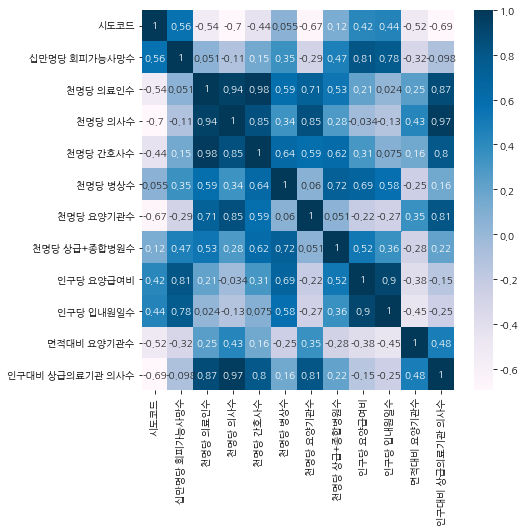

In [484]:
plt.rcParams["figure.figsize"] = (7,7)
sns.heatmap(df.corr(),
           annot = True, cmap = 'PuBu', )

## PCA 분석

In [426]:
X = df.drop(['십만명당 회피가능사망수'], axis=1).values # 독립변수의 value만 추출
y = df['십만명당 회피가능사망수'].values # 종속변수 추출

In [427]:
# 스탠다드스케일
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
df_scaled = scaler.transform(X) 

df_scaled.shape


(17, 10)

In [428]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_scaled)

X_pca = pca.transform(df_scaled)

In [429]:
print('original data: {}'.format(str(df_scaled.shape)))
print('transform data: {}'.format(str(X_pca.shape)))

original data: (17, 10)
transform data: (17, 10)


In [430]:
pca.components_

array([[-0.29558979,  0.42446944,  0.42736102,  0.40001862,  0.19427066,
         0.3522986 ,  0.18021629,  0.02304571,  0.16920784,  0.40780427],
       [ 0.31064327,  0.11388475, -0.06910967,  0.18859933,  0.46742226,
        -0.19250313,  0.4418184 ,  0.50153787, -0.35943587, -0.13677083],
       [ 0.08184544, -0.00847971, -0.02666653,  0.01860866,  0.15922185,
        -0.36974293, -0.04831459,  0.29977273,  0.85848087, -0.03038426],
       [-0.03506363, -0.0115791 , -0.1087501 ,  0.07160017, -0.06469466,
        -0.3296321 ,  0.69749815, -0.60616629,  0.12003289,  0.02216842],
       [ 0.78882246,  0.03221811,  0.087645  ,  0.04178447, -0.43467187,
         0.2583423 ,  0.13960063,  0.04355619,  0.12119036,  0.27484645],
       [-0.19624638,  0.05847223, -0.00464354,  0.30552907, -0.50493754,
        -0.58120394, -0.10271634,  0.26691163, -0.23002276,  0.37045364],
       [-0.38194842, -0.20177216, -0.12774092, -0.21050927, -0.39397147,
         0.34131249,  0.4887937 ,  0.46151419

AttributeError: ignored

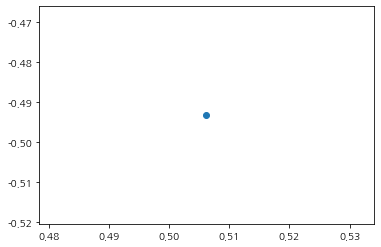

In [431]:
def biplot2(score, coeff, label, pcax, pcay, labels = None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    for i in range(len(xs)):
        plt.scatter(xs[i]*scalex, ys[i]*scaley)
        plt.annotate(label.iloc[i], xy=(xs[i]*scalex, ys[i]*scaley), ha='right')
        
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2], color='r', alpha=1)
        if labels is None:
            plt.text(coeff[i,pca1]*1.15, coeff[i,pca2]*1.15, "Var"+str(i+1), color='g', ha = 'center', va='center')
        else:
            plt.text(coeff[i,pca1]*1.15, coeff[i,pca2]*1.15, labels[i], color='g', ha='center', va='center', size=15)
    plt.xlim(-0.8, 0.75)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    
    
 ##한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



%matplotlib inline
biplot2(X_pca, pca.components_, y, 1,2,labels=X)

## PCA 분석2

In [491]:
from sklearn.preprocessing import StandardScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler().fit_transform(df)


In [492]:
# MinMax 스케일링

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scale = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)

In [493]:
X = df5.drop(['십만명당 회피가능사망수'], axis=1).values # 독립변인들의 value값만 추출
y = df5['십만명당 회피가능사망수'].values # 종속변인 추출

In [494]:
from sklearn.decomposition import PCA
# PCA 주성분분석
pca = PCA(random_state=1107)
X_p = pca.fit_transform(data_scale)

pd.Series(np.cumsum(pca.explained_variance_ratio_))

0     0.436264
1     0.773624
2     0.853237
3     0.908853
4     0.951988
5     0.974602
6     0.989285
7     0.997192
8     0.999088
9     0.999747
10    0.999953
11    1.000000
dtype: float64

In [495]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성

In [496]:
principalDf.head()

,principal component1,principal component2
0,-4.160057,3.933001
1,-2.420159,-0.518195
2,-1.961736,0.617726
3,0.627397,0.731210
4,-3.616902,-2.204566


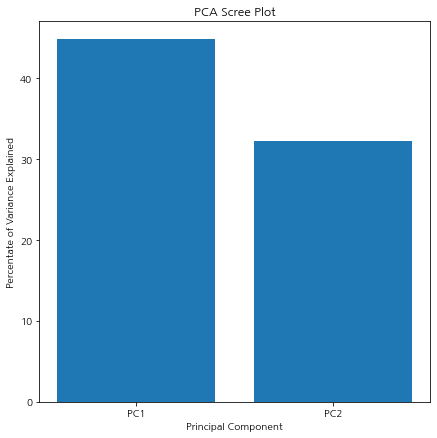

In [497]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'PC{i+1}')
    

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

In [498]:
X_pp = pd.DataFrame(X_p[:,:3], columns = ['PC1','PC2','PC3'], index = df5.index)
X_pp

,PC1,PC2,PC3
0,1.486098,0.292298,0.386057
1,0.438970,-0.501953,0.055897
2,0.630198,0.033286,-0.225430
3,0.011154,0.381833,-0.152307
4,0.676822,-0.589291,-0.396104
5,0.589862,0.006024,-0.214027
6,-0.117394,0.283181,-0.219190
7,-0.649234,1.117211,-0.229728
8,0.065077,0.797550,0.591024
9,-0.287831,-0.088619,0.038822


In [499]:
pca.explained_variance_

array([4.76257378, 3.42662388])

ValueError: ignored

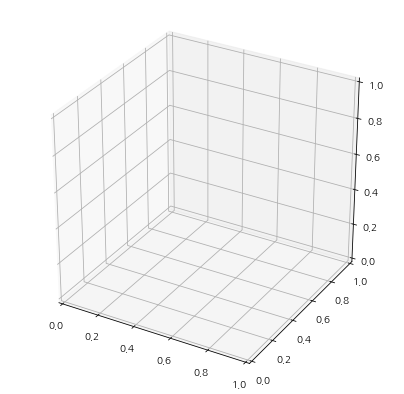

In [500]:
fig = plt.figure()
ax = fig.gca(projection = '3d')

ax.scatter(X_p[0],X_p[1],X_p[2], s=100, c = df5.index)
plt.show()

## PCA 분석3

In [485]:
pca = PCA()
pca.fit(X)
PC_score = pca.transform(X)
PC_score[:5]

array([[-2.84406415e+03,  1.44798235e+01, -7.15140051e+00,
         1.54339837e+00, -2.51082565e-01,  4.96140128e-02,
        -2.10704228e-02,  8.32982941e-04,  2.70165123e-06],
       [ 3.07492411e+03,  1.11885990e+01, -2.13897497e+00,
        -5.68717101e-01,  8.92593603e-02, -2.61728422e-02,
        -3.24195092e-02, -8.94693393e-04,  9.41605966e-07],
       [-1.71881962e+03,  6.73588077e+00,  1.00717645e+00,
         7.43869953e-01,  2.03112112e-02, -4.40657415e-02,
        -8.50938358e-03, -1.95008616e-03, -2.28036018e-06],
       [-2.13886421e+03,  3.56315474e+00, -2.12973176e+00,
        -7.33289997e-01,  3.35144979e-01,  1.48587459e-03,
         8.17832541e-02, -8.88291748e-04, -3.59550927e-06],
       [-2.35133186e+02,  9.89735798e+00,  1.07383169e+01,
        -4.03811129e-01,  9.91428578e-02, -3.10488936e-02,
         3.20689755e-03,  3.24123670e-03,  1.75928914e-06]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


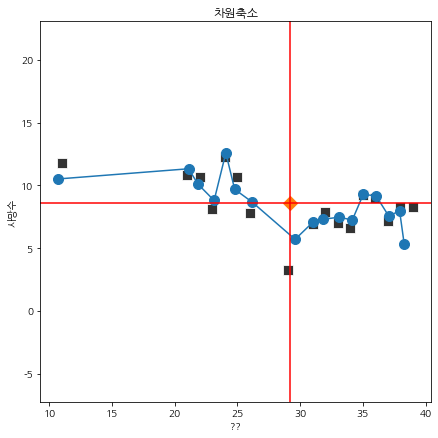

In [486]:
pca1 = PCA(n_components=3)
X_low = pca1.fit_transform(X)
X2 = pca1.inverse_transform(X_low)

plt.figure(figsize=(7, 7))
ax = sns.scatterplot(0, 1, data=pd.DataFrame(X), s=100, color=".2", marker="s")

plt.plot(X2[:, 0], X2[:, 1], "o-", markersize=10)
plt.plot(X[:, 0].mean(), X[:, 1].mean(), markersize=10, marker="D")
plt.axvline(X[:, 0].mean(), c='r')
plt.axhline(X[:, 1].mean(), c='r')
plt.grid(False)
plt.xlabel("??")
plt.ylabel("사망수")
plt.title("차원축소")
plt.axis("equal")
plt.show()